<a href="https://colab.research.google.com/github/cindyy-chen/iss_movement/blob/main/manipulating_ISS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the ISS Movement

## Required packages
- Matplotlib
- NumPy
- Pandas
- Cartopy (might not be needed at the end)
- Shapely
- GeoPandas
- MovingPandas
- HoloViews
- hvplot

In [1]:
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install cartopy
!pip install geoviews
!pip install shapely
!pip install geopandas

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
from pathlib import Path
import datetime as dt

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [5]:
import cartopy
import cartopy.crs as ccrs

In [6]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

In [8]:
import holoviews as hv
import hvplot.pandas

In [9]:
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'],
                                 frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [10]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-6.1.58+-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /usr/local/lib/python3.10/dist-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.25.2
shapely    : 2.0.3
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.17.1
hvplot     : 0.9.2
geoviews   : 1.11.1
stonesoup  : None


## Step 1: Read the CSV File

In [11]:
file_name = "https://raw.githubusercontent.com/cindyy-chen/iss_movement/main/iss_timeseries_trajectories_20240217_130914.csv"

In [12]:
df = pd.read_csv(file_name)

In [13]:
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
0,2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil
1,2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil
2,2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil
3,2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil
4,2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil
...,...,...,...,...,...,...,...,...
1996,2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile
1997,2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile
1998,2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile
1999,2024-02-17 16:16:36,-24.1985,-74.1101,False,20.6,35.8,2,Chile


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   t            2001 non-null   object 
 1   latitude     2001 non-null   float64
 2   longitude    2001 non-null   float64
 3   land_flag    2001 non-null   bool   
 4   temperature  2001 non-null   float64
 5   windspeed    2001 non-null   float64
 6   traj_id      2001 non-null   int64  
 7   country      2001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 111.5+ KB


Note that the column `t` has string as data type. We want it to be a datetime object.

## Step 2: Perform Conversions

#### Convert the `t` column into a datetime object

In [15]:
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')

Make the `t` column as index

In [16]:
df.set_index('t', inplace=True)

In [17]:
df.head(4)

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country
t,,,,,,,
2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil
2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil
2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil
2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil


#### Count the number of locations that are on land:
- `land_flag` is `True` for land and `False` otherwise (ocean).

In [18]:
df.land_flag.sum()

283

#### Convert the positions (latitude and longitude) into `Shapely` POINT objects:
- Add a `geometry` column

In [19]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.2277 -19.3273)
2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.0024 -19.5952)
2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.7763 -19.8627)
2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.5287 -20.1542)
2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.3008 -20.421)
...,...,...,...,...,...,...,...,...
2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.8537 -23.3906)
2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.6142 -23.6525)
2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.3518 -23.9376)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2024-02-17 13:09:14 to 2024-02-17 16:16:41
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   latitude     2001 non-null   float64
 1   longitude    2001 non-null   float64
 2   land_flag    2001 non-null   bool   
 3   temperature  2001 non-null   float64
 4   windspeed    2001 non-null   float64
 5   traj_id      2001 non-null   int64  
 6   country      2001 non-null   object 
 7   geometry     2001 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 127.0+ KB


In [21]:
df.head(4)

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.2277 -19.3273)
2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.0024 -19.5952)
2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.7763 -19.8627)
2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.5287 -20.1542)


## Step 3: Manipulation with GeoPandas

#### Create a GeoDataFrame

In [22]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry")
iss_gdf

,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
t,,,,,,,,
2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.22770 -19.32730)
2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.00240 -19.59520)
2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.77630 -19.86270)
2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.52870 -20.15420)
2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.30080 -20.42100)
...,...,...,...,...,...,...,...,...
2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.85370 -23.39060)
2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.61420 -23.65250)
2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.35180 -23.93760)


#### Quick plot

<Axes: >

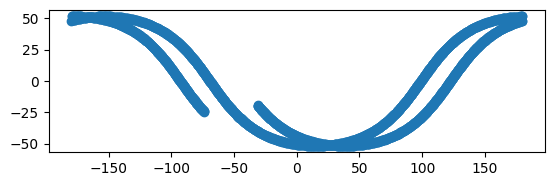

In [23]:
iss_gdf.plot()

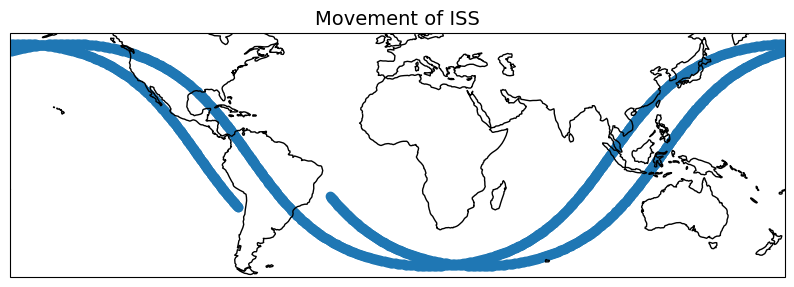

In [24]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot(
    ax=ax
)

ax.coastlines()
plt.title('Movement of ISS', fontsize = 14);

#### Plot by country crossed using Cartopy

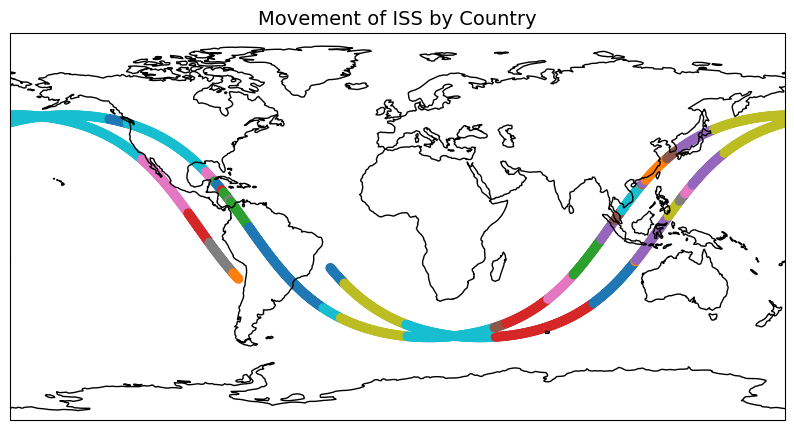

In [25]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf.plot("country", ax=ax)

ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

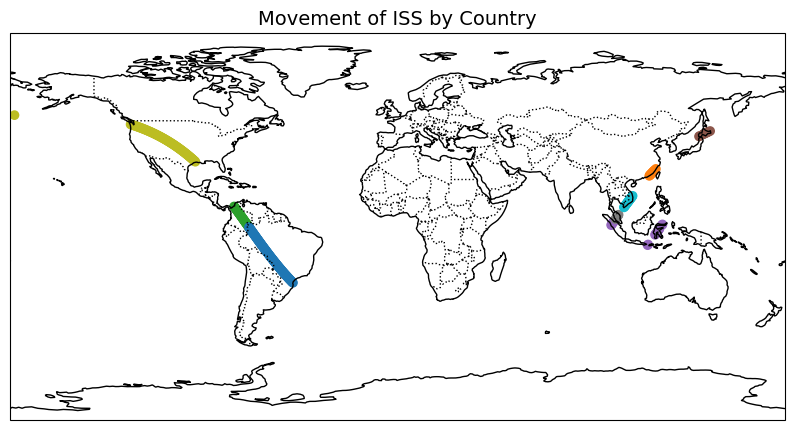

In [26]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
iss_gdf[iss_gdf.land_flag==True].plot("country", ax=ax)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

#### Plot by country crossed using the Natural Earth Database background image

In [27]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

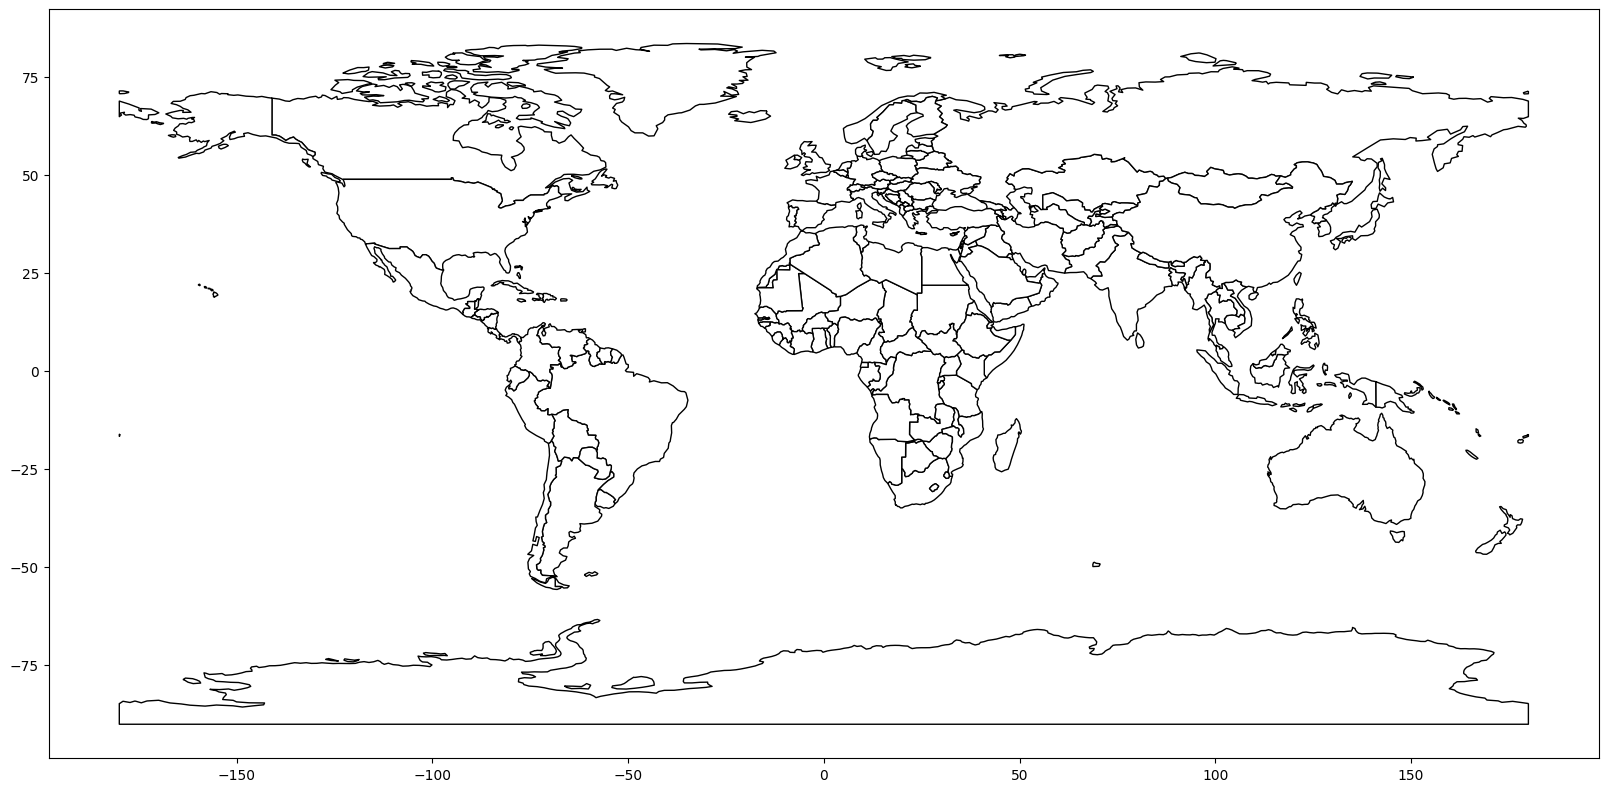

In [28]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)

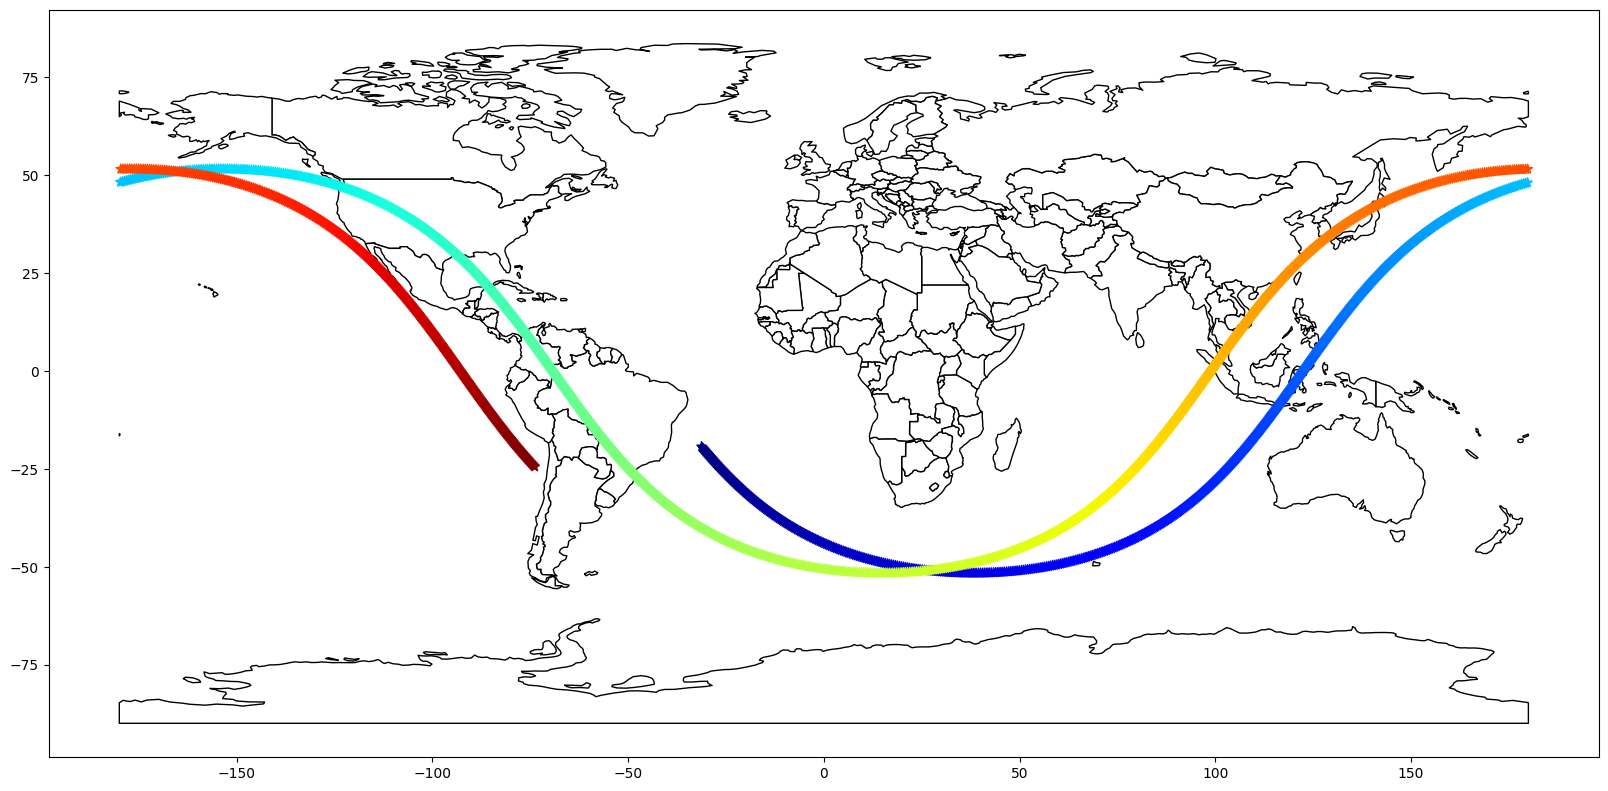

In [29]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_gdf.plot(ax=base, marker="*", markersize=50, cmap = 'jet');

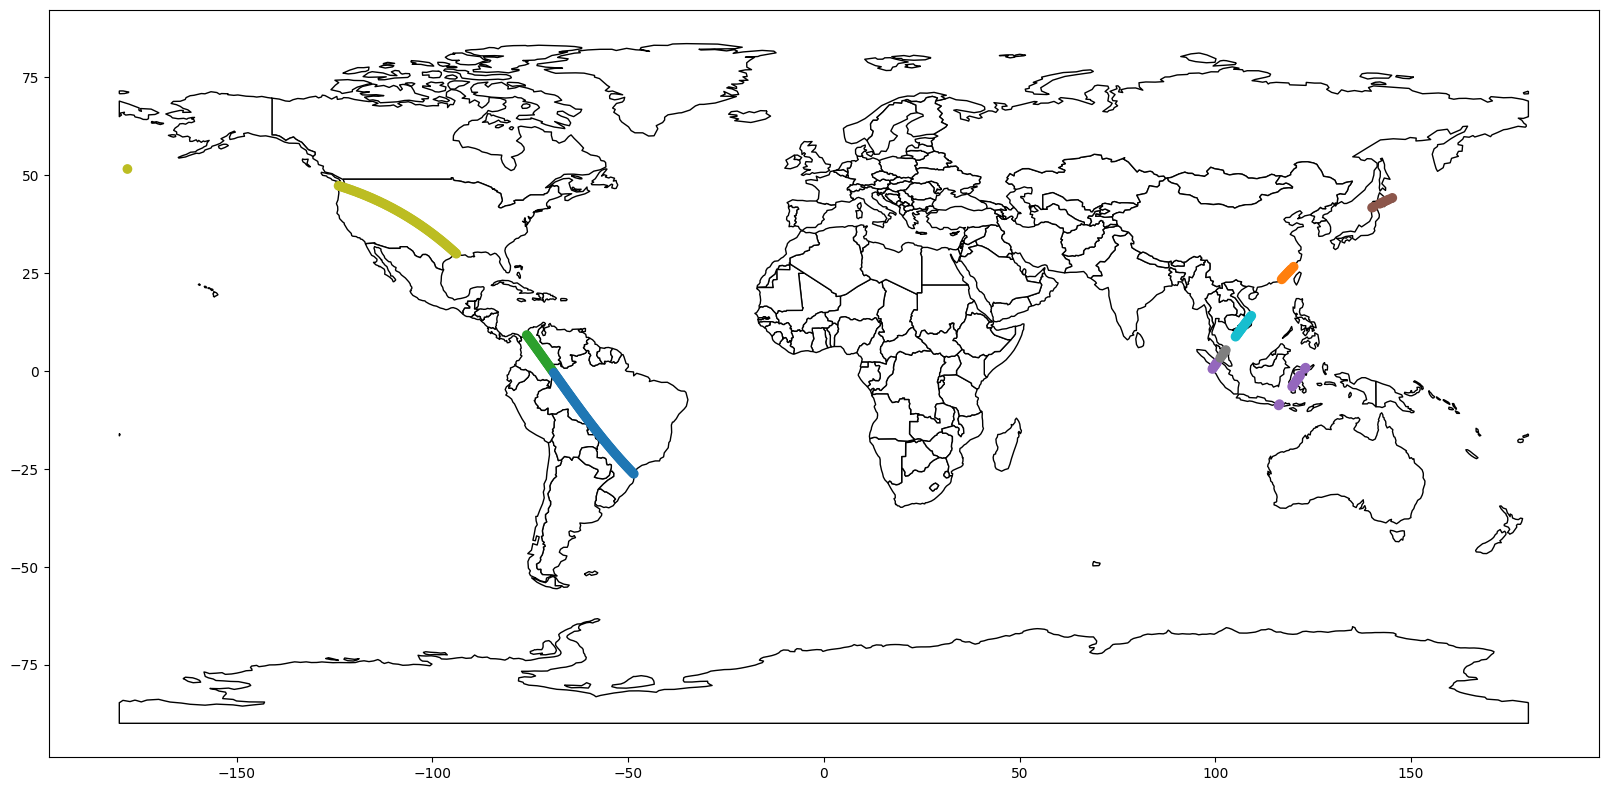

In [30]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_gdf[iss_gdf.land_flag==True].plot("country", ax=base);

# Step 4: Manipulation with MovingPandas

#### Create the MovingPandas trajectories

Create a GeoDataFram by specifying the Coordinate Reference System (CRS)

In [31]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})

Create the MovingPandas trajectories

In [32]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

#### Quick plots

Simple plot with all the trajectories

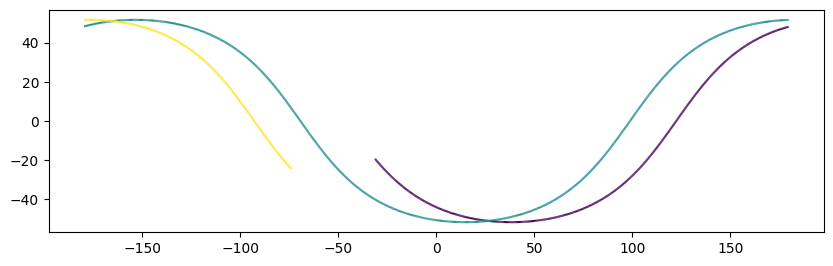

In [33]:
iss_trajc.plot(column='traj_id', figsize=(10,20));

Determine the number of trajectories

In [34]:
num_trajs = len(iss_trajc.trajectories)
print(f"Number of trajectories: {num_trajs}")

Number of trajectories: 3


Plot the individual trajectories

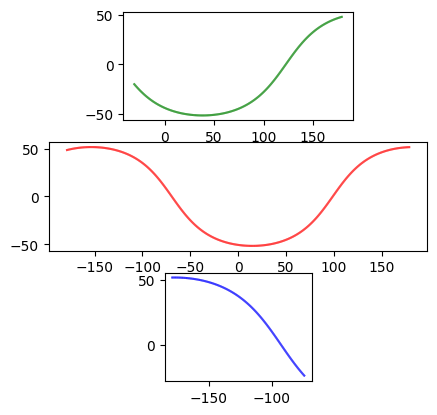

In [35]:
colors = ["green", "red", "blue", "purple"]
fig, ax = plt.subplots(num_trajs, 1)
for i in range(num_trajs):
    iss_trajc.trajectories[i].plot(ax=ax[i], color=colors[i])

#### Include Weather Data

<Axes: >

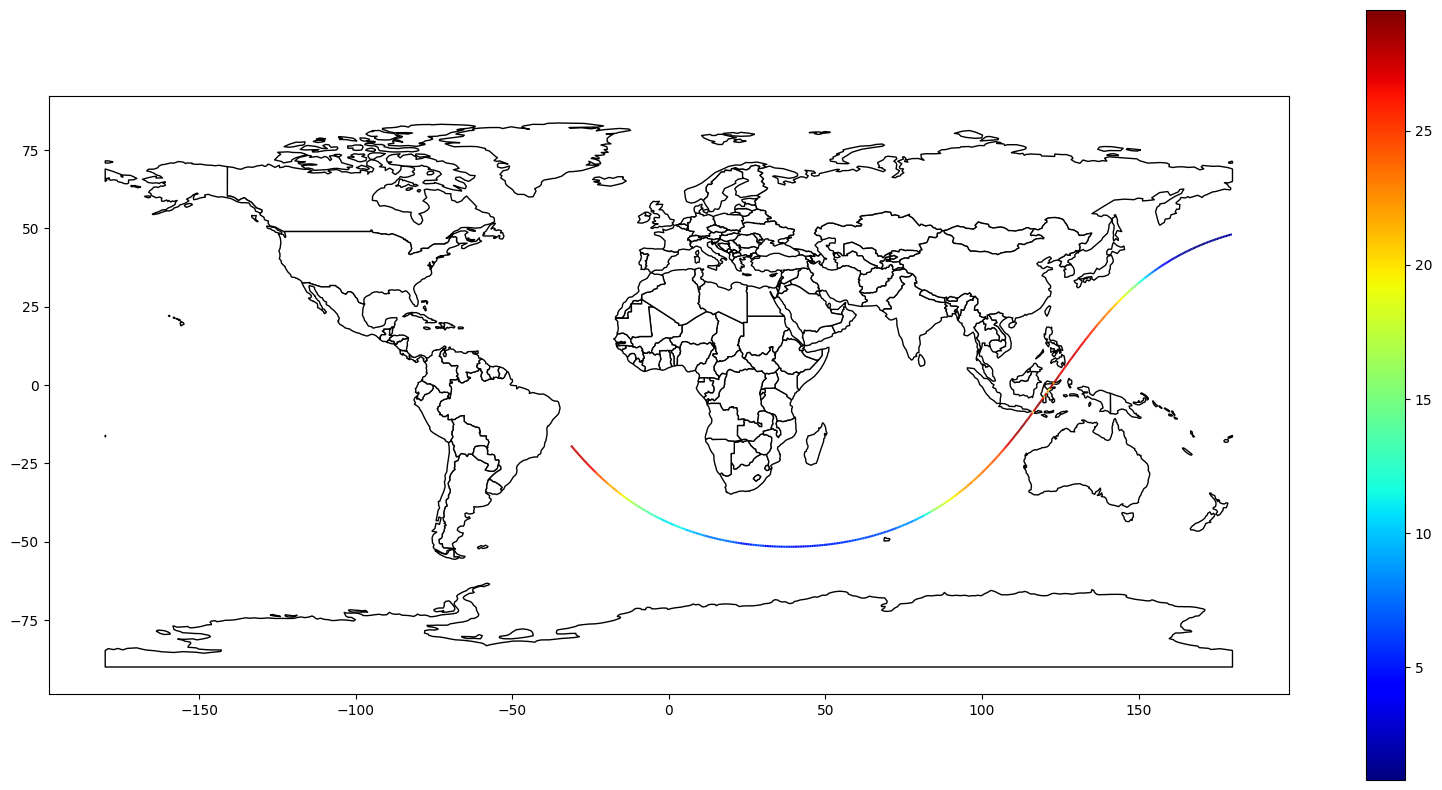

In [36]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[0].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

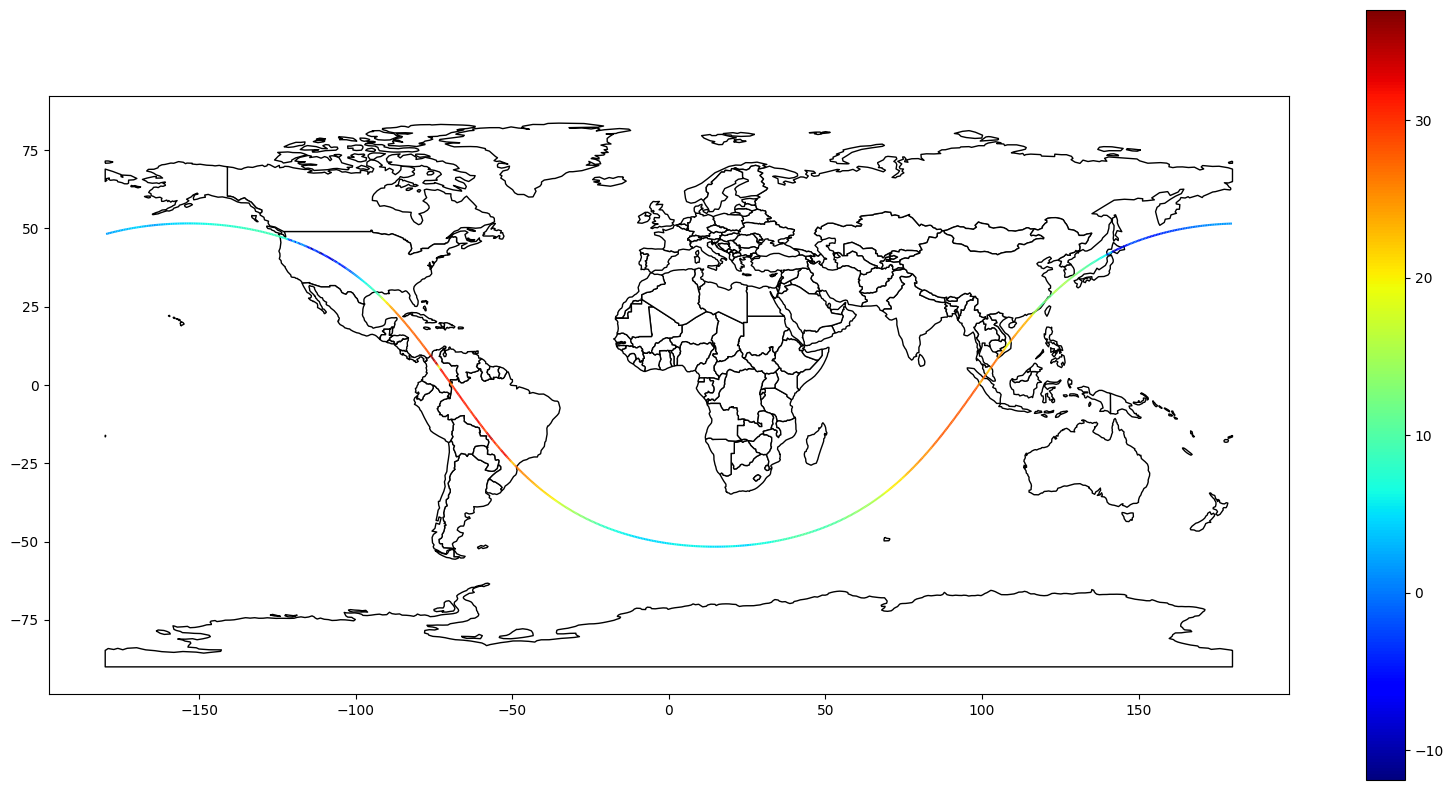

In [37]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[1].plot(ax=base, legend="true", column="temperature", cmap='jet')

<Axes: >

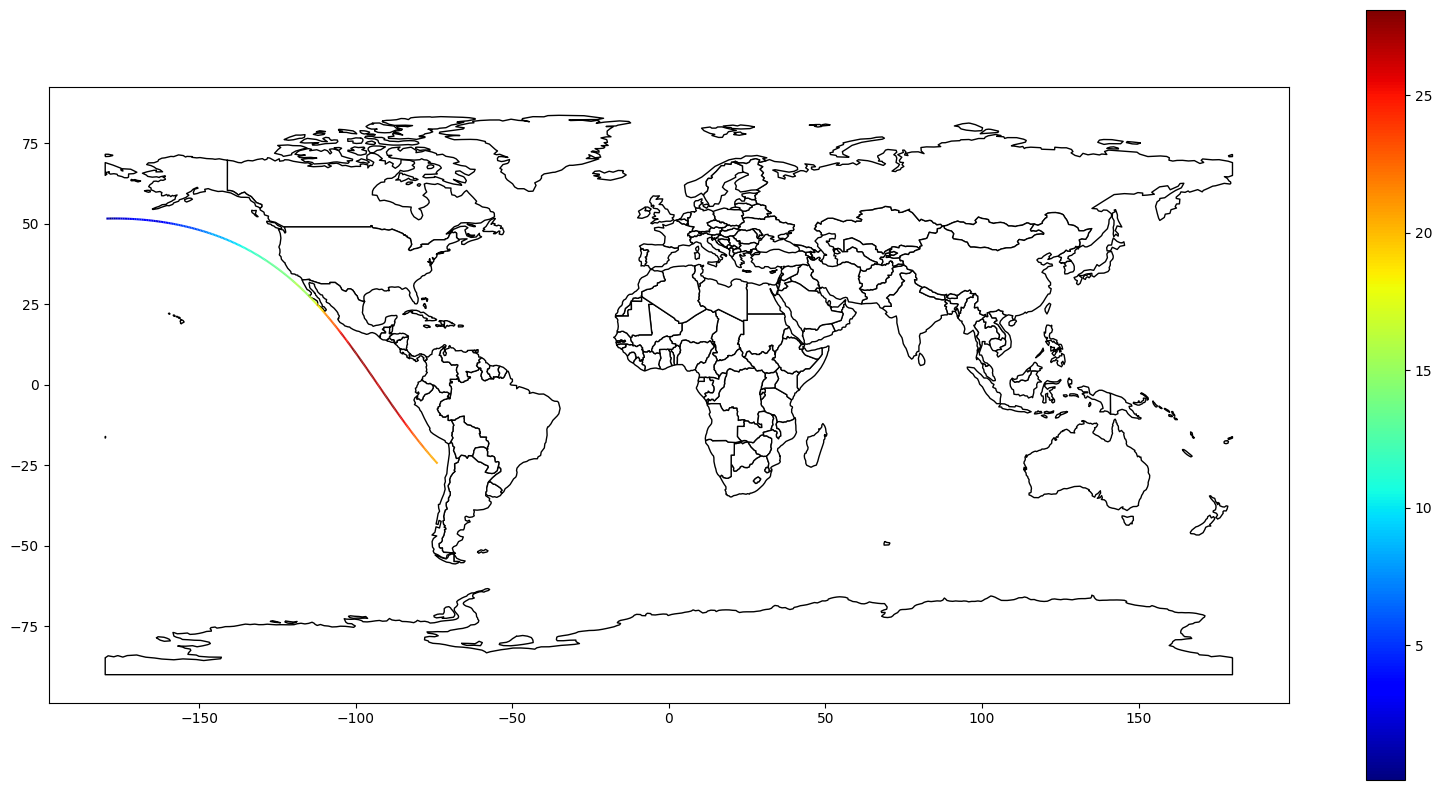

In [38]:
fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='white', edgecolor='black',)
iss_trajc.trajectories[2].plot(ax=base, legend="true", column="temperature", cmap='jet')

#### Create interactive plots with weather data

In [39]:
iss_trajc.trajectories[1].hvplot(c="windspeed", tiles="OSM")

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (windspeed)
   .Points.I :Points   [Longitude,Latitude]   (windspeed,triangle_angle)

In [40]:
gdf_path2 = gpd.GeoDataFrame(df[df.land_flag==True], crs={'init': 'epsg:4326'})
iss_trajc2 = mpd.TrajectoryCollection(gdf_path2,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")

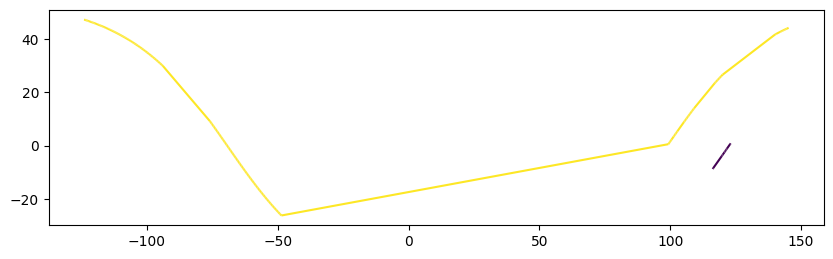

In [41]:
iss_trajc2.plot(column='traj_id', figsize=(10,20));